## Read data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split, KFold, GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from skopt import BayesSearchCV

In [2]:
raw_train = pd.read_csv('../../Datasets/train_regression.csv')
raw_test = pd.read_csv('../../Datasets/test_regression.csv')

## 1) Data pre-processing

Put the data pre-processing code. You don't need to explain it. You may use the same code from last quarter.

In [3]:
# Create copies of the raw datasets
train = raw_train.copy()
test = raw_test.copy()

# Clean 'price' column: remove '$' and ',' characters, and convert to float
train['price'] = train['price'].str.replace(',', '').str.replace('$', '', regex=False).astype(float)

In [4]:
# Convert 'host_acceptance_rate' and 'host_response_rate' columns to float and scale by dividing by 100
train['acceptance_rate'] = train['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
train['response_rate'] = train['host_response_rate'].str.replace('%', '').astype(float) / 100

test['acceptance_rate'] = test['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
test['response_rate'] = test['host_response_rate'].str.replace('%', '').astype(float) / 100

# Drop unnecessary columns
train.drop(columns=['host_acceptance_rate', 'host_response_rate'], inplace=True)
test.drop(columns=['host_acceptance_rate', 'host_response_rate'], inplace=True)


# Extract numeric values from 'bathrooms_text' column and convert to float
train['bathrooms_num'] = train['bathrooms_text'].str.extract('(\d+)').astype(float)
test['bathrooms_num'] = test['bathrooms_text'].str.extract('(\d+)').astype(float)

# Fill missing values in 'bathrooms_num' where 'Half-bath' is mentioned in 'bathrooms_text' with 0.5
train.loc[train['bathrooms_text'].str.contains('Half-bath', case=False, na=False) & train['bathrooms_num'].isna(), 'bathrooms_num'] = 0.5
test.loc[test['bathrooms_text'].str.contains('Half-bath', case=False, na=False) & test['bathrooms_num'].isna(), 'bathrooms_num'] = 0.5


In [5]:
# Convert date columns to datetime format
def strip_date(row):
    if isinstance(row, str):
        row = datetime.strptime(row, '%Y-%m-%d').date()
    return row

# Apply date conversion to train dataset
train['host_since'] = train['host_since'].apply(strip_date)
train['first_review'] = train['first_review'].apply(strip_date)
train['last_review'] = train['last_review'].apply(strip_date)

# Apply date conversion to test dataset
test['host_since'] = test['host_since'].apply(strip_date)
test['first_review'] = test['first_review'].apply(strip_date)
test['last_review'] = test['last_review'].apply(strip_date)

# ----- #

# Calculate months since various dates for train dataset
train['host_since_in_months'] = round(((datetime.now().date() - train['host_since']).dt.days) / 30, 2)
train['first_review_in_months'] = round(((datetime.now().date() - train['first_review']).dt.days) / 30, 2)
train['last_review_in_months'] = round(((datetime.now().date() - train['last_review']).dt.days) / 30, 2)

# Calculate months since various dates for test dataset
test['host_since_in_months'] = round(((datetime.now().date() - test['host_since']).dt.days) / 30,  2)
test['first_review_in_months'] = round(((datetime.now().date() - test['first_review']).dt.days) / 30, 2)
test['last_review_in_months'] = round(((datetime.now().date() - test['last_review']).dt.days) / 30, 2)


# Because the review values are extremely collinear, calculate average review scores and fill missing values with 0
train['review_scores_avg'] = np.mean(train[['review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating', 'review_scores_value', 'review_scores_location', 'review_scores_cleanliness']], axis=1)
test['review_scores_avg'] = np.mean(test[['review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating', 'review_scores_value', 'review_scores_location', 'review_scores_cleanliness']], axis=1)

train.drop(columns=['review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating', 'review_scores_value', 'review_scores_location', 'review_scores_cleanliness'], inplace=True)
test.drop(columns=['review_scores_accuracy', 'review_scores_checkin', 'review_scores_communication', 'review_scores_rating', 'review_scores_value', 'review_scores_location', 'review_scores_cleanliness'], inplace=True)

train['review_scores_avg'].fillna(value=0, inplace=True)
test['review_scores_avg'].fillna(value=0, inplace=True)

In [6]:
## Identify outliers in 'price' and 'minimum_nights'

# top and bottom 0.04% of price
lower_val = np.percentile(train[['price']], 0.07)
upper_val = np.percentile(train[['price']], 99.93)
outliers_idx_price = list(train[(train['price'] >= upper_val) | (train['price'] <= lower_val)].index)
print("Price outliers:", list(outliers_idx_price))
outliers_idx = outliers_idx_price

# # top 0.1% of minimum_nights
# # upper_lim = np.percentile(train[['minimum_nights']], 99.9)
# outliers_idx_nights = []  # list(train[train['minimum_nights'] >= upper_lim].index)
# outliers_idx = list(outliers_idx_price) + list(outliers_idx_nights)
# # print("Min nights outliers:", list(train[train['minimum_nights'] >= upper_lim].index))


print(f"\n{len(train.iloc[outliers_idx, :]['price'])} observations dropped\n")
# train.loc[outliers_idx_price, :]['price'].sort_values()

Price outliers: [523, 1626, 1823, 1848, 2067, 2380, 3129, 4865]

8 observations dropped



In [7]:
train_clean = train.drop(outliers_idx).reset_index(drop=True)
test_clean = test.copy()

Clean Transform

In [8]:
def clean_vars(row):
    # Check if 'shared' is in 'bathrooms_text' to identify shared bathrooms
    if 'shared' in str(row['bathrooms_text']):
        row['bathrooms_shared'] = "t"
        
    # Check if 'bathrooms_text' is empty and 'room_type' is 'Shared' to identify shared bathrooms
    elif pd.isna(row['bathrooms_text']):
        if 'Shared' in row['room_type']:
            row['bathrooms_shared'] = "t"              
        else:
            row['bathrooms_shared'] = "f"
    else: 
        row['bathrooms_shared'] = "f"
        
    # Convert 'Hotel room' room type to 'Private room'
    if row.loc['room_type'] == 'Hotel room':
        row['room_type'] = 'Private room'
        
    return row

# Apply the function to clean variables to train and test datasets
train_clean = train_clean.apply(clean_vars, axis=1)
test_clean = test_clean.apply(clean_vars, axis=1)


clean neighbourhoods

In [9]:
# Group small occurrences into 'Other'
neighbourhood_counts = train_clean['neighbourhood_cleansed'].value_counts()

other_hoods = [i for i in neighbourhood_counts.index if neighbourhood_counts[i] < 100]

test_only_hoods = [i for i in test_clean['neighbourhood_cleansed'].unique() 
                   if i not in neighbourhood_counts 
                   and i != 'Other']
    

In [10]:
# Create DataFrame with unique neighbourhoods
hood_df = pd.DataFrame(index=train_clean['neighbourhood_cleansed'].unique())

# Compute mean and standard deviation for each neighbourhood
grouped = train_clean.groupby('neighbourhood_cleansed')['price']
all_mean = grouped.mean()
all_std = grouped.std()

# Add mean and std to DataFrame
hood_df['mean_price'] = all_mean
hood_df['std_price'] = all_std

# Merge with counts
hood_df = hood_df.merge(neighbourhood_counts, left_index=True, right_index=True)
hood_df.rename(columns={'neighbourhood_cleansed': 'count'}, inplace=True)


# Get the 10th percentile of standard deviations
std_90 = np.percentile(hood_df.dropna(how='any')['std_price'], 10)


# Filter DataFrame
filtered_df = hood_df[((hood_df['std_price'] < std_90) | (hood_df['count'] > 100)) & (hood_df['count'] > 20)]

keep_hoods = filtered_df.index.tolist()


In [11]:
# if neighbourhood has small std or more than 100 but no neighbourhoods with less than 20
def clean_hoods(row):
    if row.loc['neighbourhood_cleansed'] not in keep_hoods:
        row['neighbourhood_grouped'] = 'Other'
        
    else:    
        row['neighbourhood_grouped'] = row.loc['neighbourhood_cleansed']
        
    return row

train_clean = train_clean.apply(clean_hoods, axis=1)
test_clean = test_clean.apply(clean_hoods, axis=1)

Clean property type

In [12]:
words_to_remove = ['place', 'room', 'private', 'shared', 'entire', ' in', ' room', ' private', ' shared', ' entire', ' in',]

# remove filler and unnecessary words from property
def remove_words(text):
    text=text.lower()
    for word in words_to_remove:
        word = word.lower()
        text = text.replace(word, '')
    return text.strip()


train_clean['property_type'] = train_clean['property_type'].apply(remove_words)
test_clean['property_type'] = test_clean['property_type'].apply(remove_words)


In [13]:
# identify value counts and make a list of neighbourhoods with more than 10
property_counts = train_clean['property_type'].value_counts()
keep = [i for i in property_counts.index if property_counts[i] > 10]

def clean_property(row):
    if row not in keep or row == "":
        row = 'Other'
      
    return row


train_clean['property_type_cleansed'] = train_clean['property_type'].apply(clean_property)
test_clean['property_type_cleansed'] = test_clean['property_type'].apply(clean_property)

train_filter_2 = train_clean.copy()
test_filter_2 = test_clean.copy()


In [14]:
train_filter_2.drop(columns=['host_id', 'host_since', 'first_review', 'last_review', 'neighbourhood_cleansed', 'property_type', 'bathrooms_text'], inplace=True)
test_filter_2.drop(columns=['host_id', 'host_since', 'first_review', 'last_review', 'neighbourhood_cleansed', 'property_type', 'bathrooms_text'], inplace=True)

number of verifications

In [15]:
try:
    train_filter_2['host_verifications'] = train_filter_2['host_verifications'].apply(ast.literal_eval)
except: pass

try:
    test_filter_2['host_verifications'] = test_filter_2['host_verifications'].apply(ast.literal_eval)
except: pass

In [16]:
train_filter_2['num_verifications'] = train_filter_2['host_verifications'].apply(len)
test_filter_2['num_verifications'] = test_filter_2['host_verifications'].apply(len)

In [17]:
def split_vers(df):
    def update_verification(row):
        ver_phone = 't' if 'phone' in row['host_verifications'] else 'f'
        ver_email = 't' if 'email' in row['host_verifications'] else 'f'
        ver_work_email = 't' if 'work_email' in row['host_verifications'] else 'f'
        return pd.Series({'ver_phone': ver_phone, 'ver_email': ver_email, 'ver_work_email': ver_work_email})

    df[['ver_phone', 'ver_email', 'ver_work_email']] = df.apply(update_verification, axis=1)

    return df


train_filter_2 = split_vers(train_filter_2).drop('host_verifications', axis=1)
test_filter_2 = split_vers(test_filter_2).drop('host_verifications', axis=1)

group small occurances into other

In [18]:
host_hood_counts = train_filter_2['host_neighbourhood'].value_counts()
keep_host_hood = host_hood_counts[host_hood_counts >= 5].index

train_filter_2['host_neighbourhood'] = train_filter_2['host_neighbourhood'].apply(lambda x: 'Other' if x not in keep_host_hood else x)
test_filter_2['host_neighbourhood'] = test_filter_2['host_neighbourhood'].apply(lambda x: 'Other' if x not in keep_host_hood else x)
# train_final[['host_neighbourhood']].value_counts()
# test_final[['host_neighbourhood']].value_counts()

# ----- #

host_loc_counts = train_filter_2['host_location'].value_counts()
keep_host_loc = host_loc_counts[host_loc_counts >= 10].index

train_filter_2['host_location'] = train_filter_2['host_location'].apply(lambda x: 'Other' if x not in keep_host_loc else x)
test_filter_2['host_location'] = test_filter_2['host_location'].apply(lambda x: 'Other' if x not in keep_host_loc else x)
# train_final['host_location'].value_counts()
# test_final['host_location'].value_counts()

Columns with missing Values

In [19]:
# Create a temporary dataframe to manipulate
train_filter_temp = train_filter_2.copy()
test_filter_temp = test_filter_2.copy()

# Change t/f to numeric 1/0
train_filter_temp['host_is_superhost'] = train_filter_2['host_is_superhost'].replace({'f': 0, 't': 1})
test_filter_temp['host_is_superhost'] = test_filter_2['host_is_superhost'].replace({'f': 0, 't': 1})

# Create model
superhost_model = smf.logit(formula="host_is_superhost ~ calculated_host_listings_count*number_of_reviews_ltm + response_rate", data=train_filter_temp).fit()

# Predict all values 
impute_superhost_train = (superhost_model.predict(train_filter_temp) > 0.5).replace({False:'f', True:'t'})
impute_superhost_test = (superhost_model.predict(test_filter_temp) > 0.5).replace({False:'f', True:'t'})

# fill na's with coordinating value from model imputation
train_filter_2['host_is_superhost'].fillna(impute_superhost_train, inplace=True)
test_filter_2['host_is_superhost'].fillna(impute_superhost_test, inplace=True)


Optimization terminated successfully.
         Current function value: 0.586516
         Iterations 8


In [20]:
# create model to impute acceptance rate
acceptance_model = smf.logit(formula="acceptance_rate ~ calculated_host_listings_count + accommodates", data=train_filter_2).fit()


# fill in missing values with the predictions from the model
predicted_acceptance = acceptance_model.predict(train_filter_2)
train_filter_2['acceptance_rate'].fillna(predicted_acceptance, inplace=True)

predicted_acceptance_test = acceptance_model.predict(test_filter_2)
test_filter_2['acceptance_rate'].fillna(predicted_acceptance_test, inplace=True)


# ----- #


# Create model to impute response rate
response_model = smf.logit(formula="response_rate ~ accommodates", data=train_filter_2).fit()


# fill in missing values with the predictions from the model
predicted_response = response_model.predict(train_filter_2)
train_filter_2['response_rate'].fillna(predicted_response, inplace=True)

predicted_response_test = response_model.predict(test_filter_2)
test_filter_2['response_rate'].fillna(predicted_response_test, inplace=True)


Optimization terminated successfully.
         Current function value: 0.192005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067442
         Iterations 8


naive imputation

In [21]:
# Fill in remaining missing values with median for numerical columns
train_filter_2.fillna(train_filter_2.median(numeric_only=True), inplace=True)
test_filter_2.fillna(test_filter_2.median(numeric_only=True), inplace=True)

#### Predictor Selection with VIF

In [22]:
import statsmodels.api as sm

non_numeric_columns = train_filter_2.select_dtypes(exclude=[np.number]).columns
data_numeric = train_filter_2.drop(columns=non_numeric_columns)

X = data_numeric.drop(columns=['price', 'id'])
y = data_numeric.price

vif = pd.DataFrame()
vif["Predictor"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif[vif['VIF'] >= 5].sort_values('VIF', ascending=False)

,Predictor,VIF
13,maximum_nights_avg_ntm,4.144480e+11
10,minimum_maximum_nights,2.203542e+11
11,maximum_maximum_nights,4.310490e+10
2,latitude,6.488237e+05
3,longitude,6.477067e+05
21,calculated_host_listings_count,3.611523e+04
22,calculated_host_listings_count_entire_homes,3.597748e+04
15,availability_60,2.565793e+02
12,minimum_nights_avg_ntm,1.868695e+02
16,availability_90,1.573983e+02


In [23]:
train_filter_3 = train_filter_2.drop(columns=['maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'calculated_host_listings_count', 'availability_60', 'host_listings_count'])  #'maximum_maximum_nights', 'minimum_maximum_nights'])
test_filter_3 = test_filter_2.drop(columns=['maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'calculated_host_listings_count', 'availability_60', 'host_listings_count'])  # 'maximum_maximum_nights', 'minimum_maximum_nights'])

In [24]:
non_numeric_columns = train_filter_3.select_dtypes(exclude=[np.number]).columns
data_numeric = train_filter_3.drop(columns=non_numeric_columns)

X = data_numeric.drop(columns=['price', 'id', 'latitude', 'longitude'])
y = data_numeric.price

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif["Predictor"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif.sort_values('VIF', ascending=False)

,Predictor,VIF
20,response_rate,53.423220
19,acceptance_rate,35.858145
10,availability_90,22.744131
3,minimum_nights,17.553907
5,minimum_minimum_nights,16.347567
26,num_verifications,16.120216
15,calculated_host_listings_count_entire_homes,15.278039
9,availability_30,14.041704
18,reviews_per_month,13.178267
1,accommodates,11.510550


In [25]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [26]:
numeric_columns = train_filter_2.select_dtypes(include=['number']).drop(columns=['price', 'id']).columns

X_train = train_filter_2.drop(columns=['price', 'id'])
X_test = test_filter_2.drop(columns=['id'])

X_train_num = X_train[numeric_columns]
y_train = train_filter_2.price

sc = StandardScaler()
sc.fit(X_train_num)

X_train_scaled = sc.transform(X_train[numeric_columns])
X_test_scaled = sc.transform(X_test[numeric_columns])

X_train_num_scaled = pd.DataFrame(X_train_scaled, columns=numeric_columns)
X_test_num_scaled = pd.DataFrame(X_test_scaled, columns=numeric_columns)

In [27]:
train_testing = train_filter_2.drop(columns=['price']) 
test_testing = test_filter_2 

train_testing_cat = train_testing.select_dtypes(exclude=['number'])
test_testing_cat = test_testing.select_dtypes(exclude=['number'])

In [28]:
enc = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
enc.fit(train_testing_cat)

drop_enc = enc.transform(train_testing_cat)
drop_enc_test = enc.transform(test_testing_cat)

train_encoded_df = pd.DataFrame(drop_enc.toarray(), columns=enc.get_feature_names_out(train_testing_cat.columns))
test_encoded_df = pd.DataFrame(drop_enc_test.toarray(), columns=enc.get_feature_names_out(test_testing_cat.columns))

keep_cols = [col for col in train_encoded_df.columns if 'Other' not in col]
keep_cols_test = [col for col in test_encoded_df.columns if 'Other' not in col]

train_encoded_df = train_encoded_df[keep_cols]
test_encoded_df = test_encoded_df[keep_cols_test]

X_train_final = pd.concat([X_train_num_scaled, train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_num_scaled, test_encoded_df], axis=1)

### Model Creation

#### Number of Trees

In [87]:
warnings.filterwarnings("ignore")
oob_rsquared={}
oob_rmse={}

for i in np.linspace(10, 200, 40, dtype=int):
    model = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=1), n_estimators=i, random_state=1,
                        n_jobs=-1, oob_score=True).fit(X_train_final, y_train)
    
    oob_rsquared[i]=model.oob_score_ 
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_, y_train))


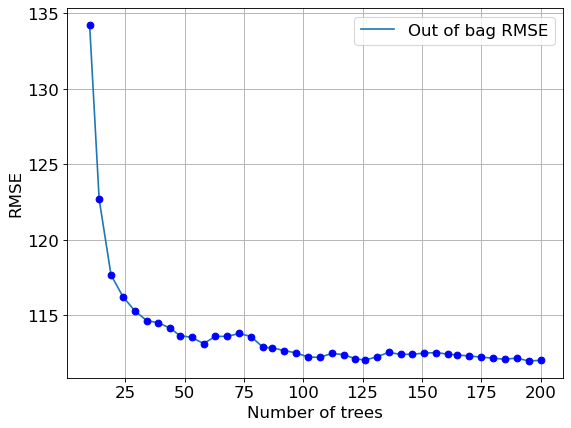

In [88]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.grid()
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### Predictor selection with feature importances

In [29]:
warnings.filterwarnings("ignore")
rand_forest = RandomForestRegressor(random_state=1, n_estimators=120)

grid = {
    'max_samples': np.arange(0.85, 0.905, 0.01),
    'max_features': np.arange(0.18, 0.21, 0.01),
    'bootstrap': [True, False]
}

cv_settings = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
gscv_forest_3 = GridSearchCV(rand_forest, grid, verbose=2, cv=cv_settings, n_jobs=4)
gscv_forest_3.fit(X_train_final, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(n_estimators=120, random_state=1),
             n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_features': array([0.18, 0.19, 0.2 ]),
                         'max_samples': array([0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ])},
             verbose=2)

In [30]:
pred_f_i = pd.DataFrame({'Predictors':gscv_forest_3.best_estimator_.feature_names_in_, 'Importances': gscv_forest_3.best_estimator_.feature_importances_}).sort_values('Importances', ascending=False)

pred_f_i_num = pred_f_i[pred_f_i['Predictors'].isin(numeric_columns)].reset_index(drop=True)
pred_f_i_cat = pred_f_i[~pred_f_i['Predictors'].isin(numeric_columns)].reset_index(drop=True)
pred_f_i

,Predictors,Importances
4,accommodates,1.505792e-01
28,bathrooms_num,1.413450e-01
5,beds,7.895064e-02
72,host_neighbourhood_Clearwater Beach,2.918900e-02
25,reviews_per_month,2.665469e-02
...,...,...
123,host_neighbourhood_Oakland,2.258742e-06
104,host_neighbourhood_Little Village,1.643359e-06
60,host_neighbourhood_Belmont Gardens,1.372578e-06
80,host_neighbourhood_East Side,1.079807e-06


In [31]:
temp_f_i_num = pred_f_i #[-34:]  # _num
scores_len_df = pd.DataFrame(columns=['score', 'diff', 'cut-off'])
break_ = 0

while len(temp_f_i_num) > 1:
    df_len = len(temp_f_i_num)
    curr_preds = list(temp_f_i_num['Predictors'])
    subset_X_train = X_train_final[curr_preds]  # X_train_final[curr_preds]
    subset_X_test = X_train_final[curr_preds]  # X_test[curr_preds]
    
    f_i_model = RandomForestRegressor(random_state=1, n_estimators=120, max_features=0.15, max_samples=0.9, bootstrap=True, n_jobs=-1) #.fit(subset_X_train, temp_y_train)
    
    mean_cv_score = np.mean(cross_val_score(f_i_model, X_train_final, y_train, cv=3, scoring='neg_root_mean_squared_error'))
    rmse_cv_score = cross_val_predict(f_i_model, X_train_final, y_train, cv=3) 
    
    scores_len_df.loc[df_len, 'score'] = -mean_cv_score 
    try:
        scores_len_df.loc[df_len, 'diff'] = (-mean_cv_score - last_cv_score)
    except:
        scores_len_df.loc[df_len, 'diff'] = None
    scores_len_df.loc[df_len, 'cut-off'] = break_
    
    print(scores_len_df.loc[df_len, 'score'], scores_len_df.loc[df_len, 'cut-off'])
    
    last_cv_score = -mean_cv_score
    break_ += 2
    temp_f_i_num = temp_f_i_num.iloc[:-2, :]


113.13860249223835 0
113.13860249223835 2
113.13860249223835 4
113.13860249223835 6
113.13860249223835 8
113.13860249223835 10
113.13860249223835 12
113.13860249223835 14
113.13860249223835 16
113.13860249223835 18
113.13860249223835 20
113.13860249223835 22
113.13860249223835 24
113.13860249223835 26
113.13860249223835 28
113.13860249223835 30
113.13860249223835 32
113.13860249223835 34
113.13860249223835 36
113.13860249223835 38
113.13860249223835 40
113.13860249223835 42
113.13860249223835 44
113.13860249223835 46
113.13860249223835 48
113.13860249223835 50
113.13860249223835 52
113.13860249223835 54
113.13860249223835 56
113.13860249223835 58
113.13860249223835 60
113.13860249223835 62
113.13860249223835 64
113.13860249223835 66
113.13860249223835 68
113.13860249223835 70
113.13860249223835 72
113.13860249223835 74
113.13860249223835 76
113.13860249223835 78
113.13860249223835 80
113.13860249223835 82
113.13860249223835 84
113.13860249223835 86
113.13860249223835 88
113.13860249223

In [32]:
keep_predictors = [col for col in list(pred_f_i.iloc[:-8, :]['Predictors']) if 'Other' not in col]

X_train_final = X_train_final[keep_predictors]
X_test_final = X_test_final[keep_predictors]


## 2) Hyperparameter tuning

### How many attempts did it take you to tune the model hyperparameters?

Total, including fixing some errors, I took 38 attempts to tune the hyperparameters (combined for both models and including predictor selection.

### Which tuning method did you use (grid search / Bayes search / etc.)?

I used grid search for the initial tuning of the model. For bagging I additionally performed Bayes to see if it could further narrow in on opitmal hyperparameters.

### What challenges did you face while tuning the hyperparameters, and what actions did you take to address those challenges?

Predictor selection with the VIF posed a challenge, there was a lot of trial and error with cross val scores in order to determine the importance threshold for predictors.

### How many hours did you spend on hyperparameter tuning?

I probably spent around 15 hours on the tuning of these models.

**Paste the hyperparameter tuning code below. You must show at least one hyperparameter tuning procedure.**

### Bagging

In [33]:
coarse_cv_settings = KFold(n_splits=3, shuffle=True, random_state=1)
fine_cv_settings = KFold(n_splits=5, shuffle=True, random_state=1)

In [48]:
base_bag_model = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=1), bootstrap=False, bootstrap_features=True, n_estimators=100, random_state=1, n_jobs=-1)

params = {
    'max_features': [0.65, 0.7, 0.75, 0.8, 0.85],
    'max_samples': np.arange(0.75, 0.95, 0.05)
}

model_ultra_fine = GridSearchCV(base_bag_model, params, verbose=2, n_jobs=-1, cv=fine_cv_settings, scoring='neg_root_mean_squared_error')
model_ultra_fine.fit(X_train_final, y_train)

model_ultra_fine.best_score_, model_ultra_fine.best_params_

(-110.50323569271043, {'max_features': 0.7, 'max_samples': 0.75})

In [35]:
print(model_ultra_fine.best_params_)
print(model_ultra_fine.best_score_)
best_max_feat = model_ultra_fine.best_params_['max_features']
best_max_samples = model_ultra_fine.best_params_['max_samples']


{'max_features': 0.7, 'max_samples': 0.75}
-110.50323569271043


#### Bagging Bayes search

In [43]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [37]:
bag_bayes_base = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=1), n_estimators=100, random_state=1, n_jobs=-1)

search_space = {
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'max_features': [0.65, 0.7, 0.75, 0.8, 0.85],
    'max_samples': np.arange(0.75, 0.95, 0.05)
}

opt = BayesSearchCV(
    estimator=bag_bayes_base,
    search_spaces=search_space,
    n_iter=50, 
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=1
)

opt.fit(X_train_final, y_train)

print(opt.best_score_, opt.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

### RandomForest

In [39]:
rand_forest = RandomForestRegressor(random_state=1, n_estimators=120)

grid = {
    'max_samples': np.arange(0.5, 1.0, 0.1),
    'max_features': np.arange(0.0, 1.0, 0.1),
    'bootstrap': [True, False]
}

cv_settings = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
gscv_forest = GridSearchCV(rand_forest, grid, verbose=2, cv=cv_settings, n_jobs=-1)
gscv_forest.fit(X_train_final, y_train)

print(gscv_forest.best_score_, gscv_forest.best_params_)

0.6360530638952503 {'bootstrap': True, 'max_features': 0.2, 'max_samples': 0.7999999999999999}


In [40]:
grid = {
    'max_samples': np.arange(0.8, 1.01, 0.05),
    'max_features': np.arange(0.10, 0.26, 0.05),
    'bootstrap': [True, False]
}


rand_forest = RandomForestRegressor(random_state=1, n_estimators=120)
cv_settings = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
gscv_forest_2 = GridSearchCV(rand_forest, grid, verbose=2, cv=cv_settings, n_jobs=4)
gscv_forest_2.fit(X_train_final, y_train)

print(gscv_forest_2.best_score_, gscv_forest_2.best_params_)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
0.6381429549974579 {'bootstrap': True, 'max_features': 0.15000000000000002, 'max_samples': 0.8500000000000001}


In [44]:
rand_forest = RandomForestRegressor(random_state=1, n_estimators=120)

grid = {
    'max_samples': np.arange(0.94, 1.005, 0.01),
    'max_features': np.arange(0.12, 0.205, 0.01),
    'bootstrap': [True, False]
}

cv_settings = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
gscv_forest_4 = GridSearchCV(rand_forest, grid, verbose=2, cv=cv_settings, n_jobs=-1)
gscv_forest_4.fit(X_train_final, y_train)

best_f_params = gscv_forest_4.best_params_

Fitting 3 folds for each of 126 candidates, totalling 378 fits


In [45]:
print(gscv_forest_4.best_score_, best_f_params)

0.646460423569749 {'bootstrap': True, 'max_features': 0.18000000000000005, 'max_samples': 0.97}


Bayes

In [47]:
bag_forest_base = RandomForestRegressor(n_estimators=120, random_state=1, n_jobs=-1)

search_space = {
    'bootstrap': Categorical([True, False]),
    'bootstrap_features': Categorical([True, False]),
    'max_features': Real(0.6, 0.9),
    'max_samples': Real(0.6, 1.0)
}

bag_bayes = BayesSearchCV(
    estimator=bag_forest_base,
    search_spaces=search_space,
    n_iter=50, 
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=1
)

bag_bayes.fit(X_train_final, y_train)

print(bag_bayes.best_score_, bag_bayes.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: Invalid parameter 'bootstrap_features' for estimator RandomForestRegressor(bootstrap=False, n_estimators=120, n_jobs=-1,
                      random_state=1). Valid parameters are: ['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

KNN Bagging

In [50]:
def dist_power_2(distance):
    return 1/(1e-10+distance**2)
def dist_power_3(distance):
    return 1/(1e-10+distance**3)
def dist_power_4(distance):
    return 1/(1e-10+distance**4)
def dist_power_5(distance):
    return 1/(1e-10+distance**5)


In [51]:
params = {
    'estimator__n_neighbors': np.arange(5, 100, 20),
    'estimator__weights': [dist_power_2, dist_power_3, dist_power_5]
}

cv_settings = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
bag_knn_model = GridSearchCV(BaggingRegressor(estimator=KNeighborsClassifier(), n_estimators=150), params, cv=cv_settings, scoring='accuracy', verbose=2, n_jobs=8)

bag_knn_model.fit(X_train_final, y_train)
print(bag_knn_model.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'estimator__n_neighbors': 5, 'estimator__weights': <function dist_power_2 at 0x00000223E10A0CC0>}


In [52]:
np.sqrt(mean_squared_error(y_train, cross_val_predict(bag_knn_model.best_estimator_, X_train_final, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=1))))

118.74746372403958

In [55]:
params = {
    'estimator__n_neighbors': np.arange(2, 25, 5),
    'estimator__weights': ['uniform', 'distance', dist_power_2, dist_power_3]
}

cv_settings = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
bag_knn_model_2 = GridSearchCV(BaggingRegressor(estimator=KNeighborsClassifier(), n_estimators=150), params, cv=cv_settings, scoring='accuracy', verbose=2, n_jobs=-1)

bag_knn_model_2.fit(X_train_final, y_train)
print(bag_knn_model_2.best_params_)

{'estimator__n_neighbors': 2, 'estimator__weights': 'uniform'}


In [54]:
np.sqrt(mean_squared_error(y_train, cross_val_predict(bag_knn_model_2.best_estimator_, X_train_final, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=1))))

126.31046465850385

**Paste the optimal hyperparameter values below.**

In [56]:
print('Best bagging params:', model_ultra_fine.best_params_)
print('Best random forest params:', best_f_params)

Best bagging params: {'max_features': 0.65, 'max_samples': 0.75}
Best random forest params: {'bootstrap': True, 'max_features': 0.16, 'max_samples': 0.98}


* Best bagging params: {'max_features': 0.65, 'max_samples': 0.75}
* Best random forest params: {'bootstrap': True, 'max_features': 0.16, 'max_samples': 0.98}

## 3) Model

Using the optimal model hyperparameters, train the model, and paste the code below.

In [50]:
best_bag_model = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=1),
                                  n_estimators=100,
                                  bootstrap=False,
                                  bootstrap_features=True,
                                  max_features= best_max_feat,
                                  max_samples= best_max_samples).fit(X_train_final, y_train)

best_forest_model = RandomForestRegressor(bootstrap=True,
                                          max_features=0.7, 
                                          max_samples=0.75, 
                                          random_state=1, n_estimators=120)


In [56]:
# # Bagging GSCV
# y_preds_test = best_bag_model.predict(X_test_final)

# RandomForest GSCV
y_preds_test = gscv_forest_4.predict(X_test_final)

## 4) Put any ad-hoc steps for further improving model accuracy

In [57]:
y_preds = y_preds_test*1.05

## 5) Export the predictions in the format required to submit on Kaggle

In [58]:
predicted_values = pd.DataFrame(y_preds, columns=['predicted'])

# add listing id to the predicted values dataframe and set the index to the id value
predicted_values = predicted_values.merge(test_filter_2['id'], left_index=True, right_index=True).set_index('id').rename(columns={0:'predicted'})
predicted_values

# predicted_values.to_csv('Tree_reg_model_predictions_b.csv')